In [10]:
#General packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

#Pre-processing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split

#Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
#Path to your vehicles.csv
vehicles_path = './data/vehicles.csv'

In [3]:
#Read in the raw csv
raw_df = pd.read_csv(vehicles_path)

In [4]:
raw_df.columns

Index(['Unnamed: 0', 'id', 'url', 'region', 'region_url', 'price', 'year',
       'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer',
       'title_status', 'transmission', 'VIN', 'drive', 'size', 'type',
       'paint_color', 'image_url', 'description', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')

# Dataset

## Data Description

Useless columns
* Unnamed
* url
* region_url
* image_url
* lat
* long
* posting_date
* VIN
* region
* id

In [6]:
#Drop useless columns
df = raw_df.drop(['Unnamed: 0', 'url', 'region_url', 'image_url', 'lat','long','posting_date', 'VIN','id'],axis=1)

In [191]:
df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,description,state
0,auburn,35990,2010.0,chevrolet,corvette grand sport,good,8 cylinders,gas,32742.0,clean,other,rwd,NaN,other,NaN,Carvana is the safer way to buy a car During t...,al
1,auburn,7500,2014.0,hyundai,sonata,excellent,4 cylinders,gas,93600.0,clean,automatic,fwd,NaN,sedan,NaN,I'll move to another city and try to sell my c...,al
2,auburn,4900,2006.0,bmw,x3 3.0i,good,6 cylinders,gas,87046.0,clean,automatic,NaN,NaN,SUV,blue,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al
3,auburn,2000,1974.0,chevrolet,c-10,good,4 cylinders,gas,190000.0,clean,automatic,rwd,full-size,pickup,blue,1974 chev. truck (LONG BED) NEW starter front ...,al
4,auburn,19500,2005.0,ford,f350 lariat,excellent,8 cylinders,diesel,116000.0,lien,automatic,4wd,full-size,pickup,blue,2005 Ford F350 Lariat (Bullet Proofed). This t...,al


## EDA

### Initial

In [192]:
#Number of null values per column
df.isna().sum()

region               0
price                0
year              1050
manufacturer     18220
model             4846
condition       192940
cylinders       171140
fuel              3237
odometer         55303
title_status      2577
transmission      2442
drive           134188
size            321348
type            112738
paint_color     140843
description         70
state                0
dtype: int64

In [193]:
#What types of fuel are there besides gas and electric?
df['fuel'].value_counts()

gas         399399
diesel       31077
other        16359
hybrid        5790
electric      2351
Name: fuel, dtype: int64

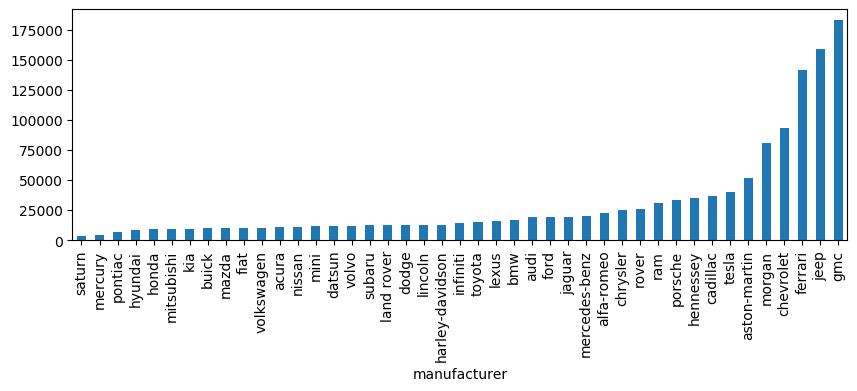

In [194]:
plt.figure(figsize = (10,3))
df.groupby('manufacturer')['price'].mean().sort_values().plot(kind='bar');

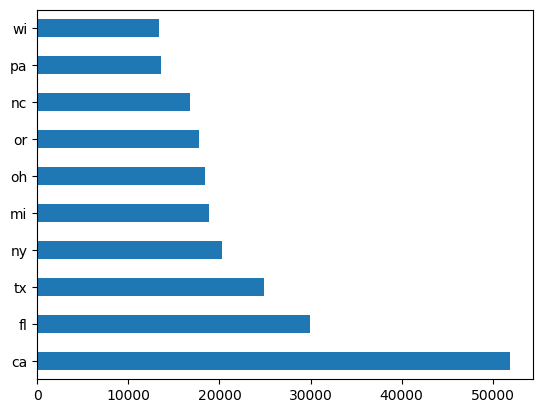

In [195]:
df['state'].value_counts()[:10].plot(kind='barh');

### Preprocessing

In [174]:
#Snippet of the data
df.head(3)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,description,state
0,7240372487,auburn,35990,2010.0,chevrolet,corvette grand sport,good,8 cylinders,gas,32742.0,clean,other,rwd,NaN,other,NaN,Carvana is the safer way to buy a car During t...,al
1,7240309422,auburn,7500,2014.0,hyundai,sonata,excellent,4 cylinders,gas,93600.0,clean,automatic,fwd,NaN,sedan,NaN,I'll move to another city and try to sell my c...,al
2,7240224296,auburn,4900,2006.0,bmw,x3 3.0i,good,6 cylinders,gas,87046.0,clean,automatic,NaN,NaN,SUV,blue,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al


In [5]:
#Decide where to cutoff outliers
df['price'].describe()

NameError: name 'df' is not defined

In [185]:
#Get a sense of what thresholds to use for price filtering
df['price'].quantile(0.9998), df['price'].quantile(0.9999)

(235675.1487999782, 999999.1787999999)

In [7]:
#Remove immediately useless columns
cars_naless = df.dropna()

#Remove listings with price equal to 0
cars_0_naless = cars_naless[cars_naless['price'] != 0].reset_index(drop=True)

#Remove listings with price greater than $300,000 or less than $100
cleaned_cars = cars_0_naless[(cars_0_naless['price'] < 300000) & (cars_0_naless['price'] > 100)]#.sort_values('price',ascending=False)#[:20]

#Remove listings with odometer milage graeter than 500,000 miles
#Car would probably explode by then
cleaned_cars = cleaned_cars[cleaned_cars['odometer'] < 500000]

We can take a look at the unique values within our columns. Categorical columns with a too high amount of unique values can be discarded in our model. They'll simply add too many columns in a one hot encoding. We can now decide which columns to keep.

In [200]:
#Get Number of unique values
cleaned_cars.nunique()

region            404
price            4677
year               90
manufacturer       41
model           10220
condition           6
cylinders           8
fuel                5
odometer        30844
title_status        6
transmission        3
drive               3
size                4
type               13
paint_color        12
description     71416
state              51
dtype: int64

In [221]:
#Pick your categorical cols and numeric cols
categorical_cols = ['manufacturer','condition','cylinders','fuel','title_status','transmission','drive','size','type','paint_color','state']
numer_cols = ['year','odometer']

## Correlation with Price

We see that year correlates positively with price, which makes sense. Generally, you'd probably pay more for a 2019 model car then a 2004 one. 

Intuitively, it would make sense that odometer(mileage) is correlated with price inversely(negatively). So the more miles you have on a car, the less you could sell it for. But here, there doesn't seem to be much correlation at all. Why is that?

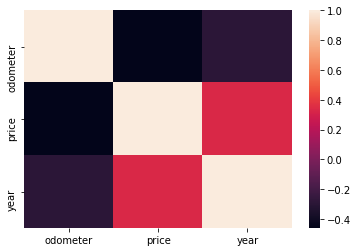

In [73]:
sns.heatmap(cleaned_cars[['odometer','price','year']].corr());

One potential reason for this is due to some sort of confounding variable(s), like manufacturer or model. We can take a look at the correlation within different groups to see if there's some stark contrasts.

In [81]:
def car_filter(frame, manufacturer):
    "Gets you the dataframe containing rows of only a single manufacturer"
    df = frame[frame['manufacturer']==manufacturer]
    return df

In [154]:
#This gets correlation between price and odometer, for each manufacturer
only_one_manu = car_filter(cleaned_cars,'honda')
manu_corrs = dict({})
for manufacturer in cleaned_cars['manufacturer'].unique():
    only_one_manu = car_filter(cleaned_cars,manufacturer)
    correlation = only_one_manu[['odometer','price','year']].corr()['price']['odometer']
    manu_corrs[manufacturer] = abs(correlation)

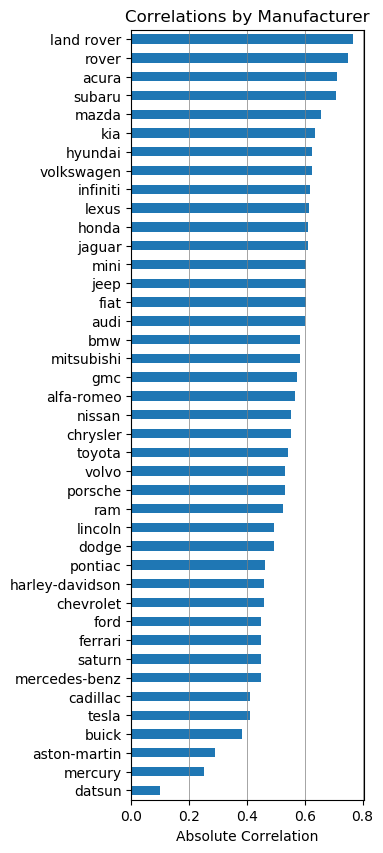

In [156]:
#Plot correlations in a bar graph

#with plt.xkcd()
#plt.rcdefaults()
plt.figure(figsize = (3,10))
plt.yticks(fontsize=10)
plt.xlabel('Absolute Correlation')
plt.title('Correlations by Manufacturer')
pd.Series(manu_corrs).sort_values().plot(kind='barh')
plt.grid(b=True,which='major',linewidth=0.5, axis='x', color='grey');

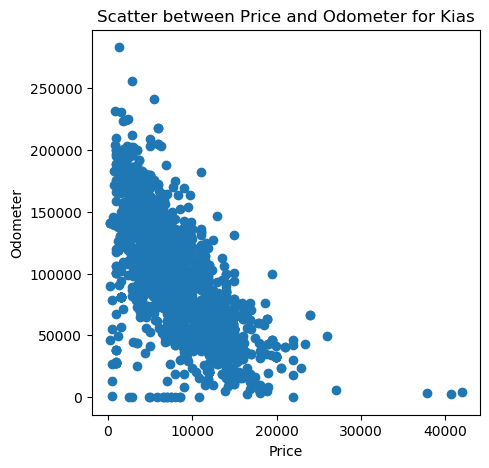

In [168]:
#Let's take a look at one of the individual groups in a scatter: Kia
plt.figure(figsize=(5,5))
plt.title('Scatter between Price and Odometer for Kias')
plt.xlabel("Price")
plt.ylabel("Odometer")
plt.scatter(x=car_filter(cleaned_cars,'kia')['price'], y=car_filter(cleaned_cars,'kia')['odometer']);

# Literature

### Data Set Origin and Similar Data

We use a dataset originating from Kaggle. It is scraped frequently from Craiglist by Austin Reese and is the result of a school project. Information about the dataset and how it was scraped can be found at the Kaggle page and also includes a link to the GitHub repository to the scraping script. https://www.kaggle.com/austinreese/craigslist-carstrucks-data. By looking through the GitHub repository, we can understand that the way the data is scraped is by visiting the Craiglist page for every city and then grabbing data from the cars+trucks sub-category page. This is useful so we can visit the data generating process itself if need be. For example, we could see whether a column was generated by the scraping tool itself or if it was a requirement when the user was making the Craiglist post. This dataset was used to provide Kaggle users a dataset for whatever purpose they personally deem fit, and does not have a specific intended application. For our purposes, we are interested in predicting the user submitted listing price of a vehicle given it's respective features.

A similar dataset focusing on car features and MSRP is also hosted on Kaggle. https://www.kaggle.com/CooperUnion/cardataset. Rather than being Craiglist postings, this was data was scraped from Edmunds. Edmunds is used car resale company. Sadly, a link to the scraper is not available, so we would not be able to investigate how the data was exactly gathered. The motivating features here overlap greatly with our own dataset: model, year, cylinders, transmission. Since listings are posted by the company themselves, the data here is much more consistent and clean. If we needed ideas for how to go about predicting price, we could definitely take a look at the notebooks made by other users for this data set.

### Existing Methods

There is a significant amount of work already done in the area of predicting prices of used cars. Pal et al. have written a paper on predicting price using a similar dataset:  https://arxiv.org/ftp/arxiv/papers/1711/1711.06970.pdf. This data also focuses on used car sales, but from the German subsidiary of eBay. Their work compared two models: linear regression and random forest regression. The results show that a random forest model proved more robust to overfitting than a linear regression model. In their hyper parameter tuning, they found success with n_estimators=500 and max_features=num_features. These results would serve as a good place to start in our own model selection and tuning, as we cannot directly use their parameter values due to a difference in datasets. Additionally, Pal et al. found the most useful features to be kilometer(mileage), brand, and vehicle type. The input data was filtered to exclude outliers and irrelevant data, much like our own model.

Another example seems to belong to a group of students in a computer science course at Stanford http://cs229.stanford.edu/proj2019aut/data/assignment_308832_raw/26612934.pdf . Their raw dataset overlapped in features with ours: price, make, milage, year, and model. They tested a variety of models using R^2 as an accuracy metric: linear regression, gradient boost, random forest, light gbm, xgboost, k-means linear regression, and a deep neural network. The results show that among both the training and test accuracy, random forest proved the best. They chose to use a value of 36 for their max_depth parameter. If we needed to arbitrarily pick an initial value for our own random forest, then we could use 36 as well.



http://cs229.stanford.edu/proj2019aut/data/assignment_308832_raw/26612934.pdf

# Predictive Task

# Model

In [8]:
#Pick your categorical cols and numeric cols
categorical_cols = ['manufacturer','condition','cylinders','fuel','title_status','transmission','drive','size','type','paint_color','state']
numer_cols = ['year','odometer']

In [9]:
#This is a dataframe of just features
raw_features = cleaned_cars[categorical_cols + numer_cols]

In [19]:
#Pre-Processing "Pipeline"

#Transform the numerical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

#Transform the categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#Combine into pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numer_cols),
        ('cat', categorical_transformer, categorical_cols)]
)

In [20]:
#Features and labels
X = preprocessor.fit_transform(raw_features)
y = cleaned_cars['price'].values

In [21]:
#Get your train and test(validation and test) data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### GridsearchCV

In [31]:
regr = RandomForestRegressor(max_depth=36)

In [30]:
#Parameters to tune
parameters = {'n_estimators':[1, 2, 4, 8, 16]}

In [35]:
#Create a gridsearch
clf = GridSearchCV(regr, parameters)

In [36]:
clf

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=36,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_j

In [37]:
a = time.time()
clf.fit(X_train,y_train)
b=time.time()
print(b-a)

1097.6209552288055


In [43]:
#Results of the grid search
pd.DataFrame(clf.cv_results_)[['rank_test_score','param_n_estimators','mean_test_score']]

,rank_test_score,param_n_estimators,mean_test_score
0,5,1,0.678202
1,4,2,0.724859
2,3,4,0.781353
3,2,8,0.807081
4,1,16,0.815318


In [45]:
clf.best_params_['n_estimators']

16

In [46]:
#Turn your test set into validation and testt sets
X_validation, X_testt, y_validation, y_testt = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [52]:
def RMSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return np.sqrt(sum(differences) / len(differences))

In [53]:
best_regr = RandomForestRegressor(n_estimators=clf.best_params_['n_estimators'],max_depth=36)

In [54]:
best_regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=36, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=16, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [57]:
#Training Error
train_preds = best_regr.predict(X_train)

rmse_train = RMSE(train_preds,y_train)
r2_train = best_regr.score(X_train, y_train)

print('Training Error')
print("RMSE: " + str(rmse_train) + " R2: " + str(r2_train))

Training Error
RMSE: 2034.9555726634167 R2: 0.9672497772643048


In [58]:
#Validation Error
validation_preds = best_regr.predict(X_validation)

rmse_train = RMSE(validation_preds,y_validation)
r2_train = best_regr.score(X_validation, y_validation)

print('Validation Error')
print("RMSE: " + str(rmse_train) + " R2: " + str(r2_train))

Validation Error
RMSE: 4642.661827088322 R2: 0.8294506531440728


In [60]:
#Test Error
test_preds = best_regr.predict(X_testt)

rmse_train = RMSE(test_preds,y_testt)
r2_train = best_regr.score(X_testt, y_testt)

print('Test Error')
print("RMSE: " + str(rmse_train) + " R2: " + str(r2_train))

Test Error
RMSE: 4881.250788967512 R2: 0.82147612859481


# Results